# Seminar 2. Normal distribution

_Dimitri Sotnikov_

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=["#5b6c64", "#B56246", "#322B4D", "#28BC9C", "#71074E"]) 

## Convergence diagram

In [3]:
def plot_convergence_diagram(sample, fisrt_idx = 100, ax = None, label = "MC sample", confidence_level = 0.95, plot_ci = False, **kwargs):
    ns = np.arange(1, len(sample) + 1)
    x = np.log(ns)[fisrt_idx:]
    y = (np.cumsum(sample) / ns)[fisrt_idx:]
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(x, y, label=label, **kwargs)
    if plot_ci:
        mean_sq = (np.cumsum(sample**2) / ns)[fisrt_idx:]
        quantile = norm.ppf((1 + confidence_level) / 2)
        accuracy = quantile * np.sqrt((mean_sq - y**2) / ns[fisrt_idx:]) 
        ax.fill_between(x, y - accuracy, y + accuracy, alpha=0.3)
    ax.legend()
    ax.set_xlabel("$\log(n)$")
    
def mc_results(sample, confidence_level=0.95, decimals=4):
    n = len(sample)
    mean = sample.mean()
    var = sample.var()
    quantile = norm.ppf((1 + confidence_level) / 2)
    accuracy = quantile * np.sqrt(var / n)
    return str(np.round(mean, decimals=decimals)) + " ± " + str(np.round(accuracy, decimals=decimals))

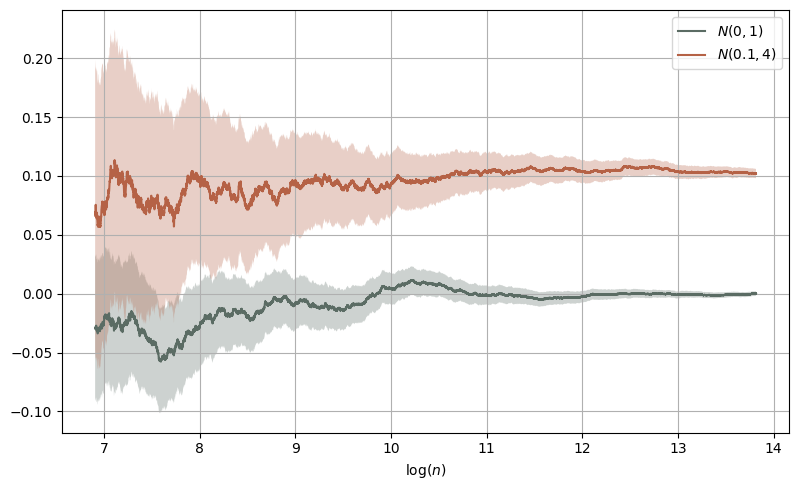

In [ ]:
rng = np.random.default_rng(seed=42) # Fixing the random seed is crucial for reproducibility!
size = 10**6

sample_1 = rng.normal(size=size)

mu, sigma = 0.1, 2
sample_2 = rng.normal(size=size) * sigma + mu

fig, ax = plt.subplots()
plot_convergence_diagram(sample_1, ax=ax,label="$N(0, 1)$", fisrt_idx=1000, plot_ci=True)
plot_convergence_diagram(sample_2, ax=ax,label=f"$N{mu, sigma**2}$", fisrt_idx=1000, plot_ci=True)



# графики наглядно показывают, что Монте-Карло сходится хорошо на больших значениях выборки


In [12]:
mc_results(sample_2)

'0.102 ± 0.0039'

## Density and CDF tests

In [13]:
from typing import Callable
import scipy
import statsmodels.api as sm

def density_test(sample, density: Callable, bins=50, alpha=0.4, n_grid=10**4):
    fig, ax = plt.subplots()
    ax.hist(sample, bins=bins, density=True, alpha=alpha, label="Empirical density")
    x_grid = np.linspace(sample.min(), sample.max(), num=n_grid)
    ax.plot(x_grid, density(x_grid), label="PDF")
    ax.legend()
    
def cdf_test(sample, cdf: Callable, bins=50, alpha=0.4, n_grid=10**4):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    x_grid = np.linspace(sample.min(), sample.max(), num=n_grid)
    ecdf = sm.distributions.ECDF(sample)
    ax[0].plot(x_grid, cdf(x_grid), "k--", label="Exact CDF")
    ax[0].plot(x_grid, ecdf(x_grid), label=r"Empirical CDF")
    ax[0].legend()
    
    ecdf_unif = sm.distributions.ECDF(cdf(sample))
    u_grid = np.linspace(0, 1, n_grid)
    ax[1].plot(u_grid, u_grid, "k--", label="y=x")
    ax[1].plot(u_grid, ecdf_unif(u_grid), label=r"Empirical CDF of F(X)")
    ax[1].legend()

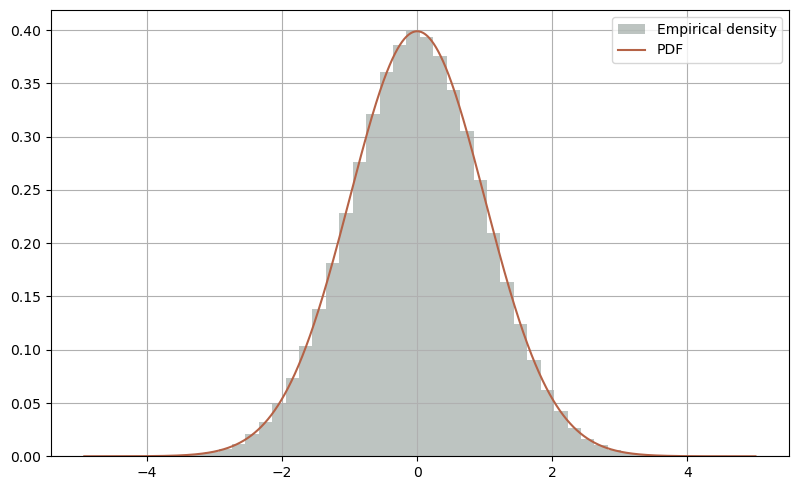

In [14]:
density_test(sample=sample_1, density=norm.pdf)

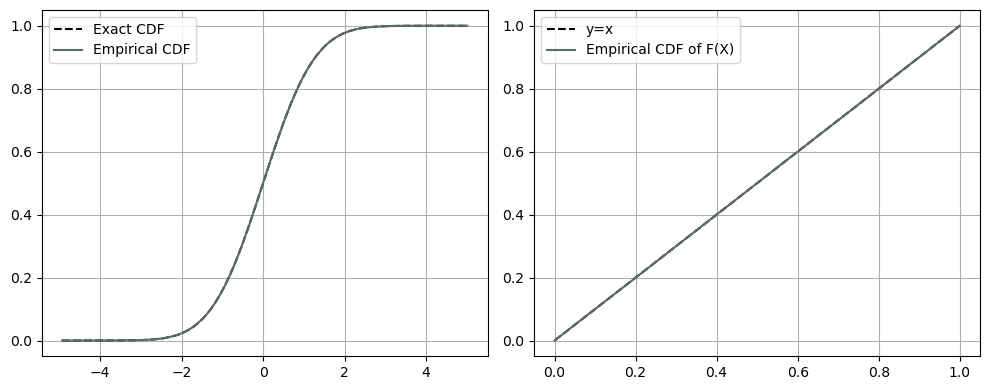

In [15]:
cdf_test(sample=sample_1, cdf=norm.cdf)

## **Problem 1.** Standard Normal distribution via AR

In [16]:
def laplace_pdf(x, mu=0, lam=1):
    return np.exp(-np.abs(x - mu) * lam) * lam / 2

def normal_pdf(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

In [17]:
M = np.sqrt(2 / np.pi) * np.exp(0.5)
print(f"M = {M}, \nAcceptance probability = {1 / M}")

M = 1.315489246958914, 
Acceptance probability = 0.7601734505331403


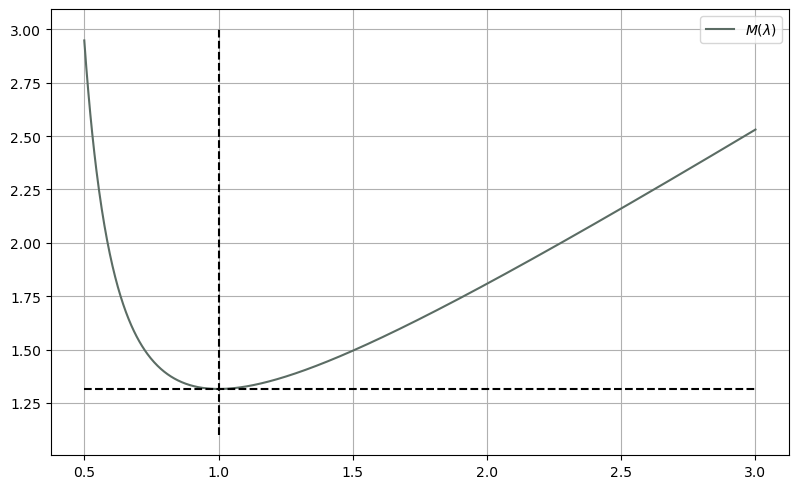

In [18]:
lam_grid = np.linspace(0.5, 3, 1000)
M_grid = np.sqrt(2 / np.pi) * lam_grid * np.exp(1 / 2 / lam_grid**2)
plt.plot(lam_grid, M_grid, label=r"$M(\lambda)$")
plt.vlines(1, 1.1, 3, ls="--", color="k")
plt.hlines(M, lam_grid[0], lam_grid[-1], ls="--", color="k")
plt.legend()

#### Check the bound for densities

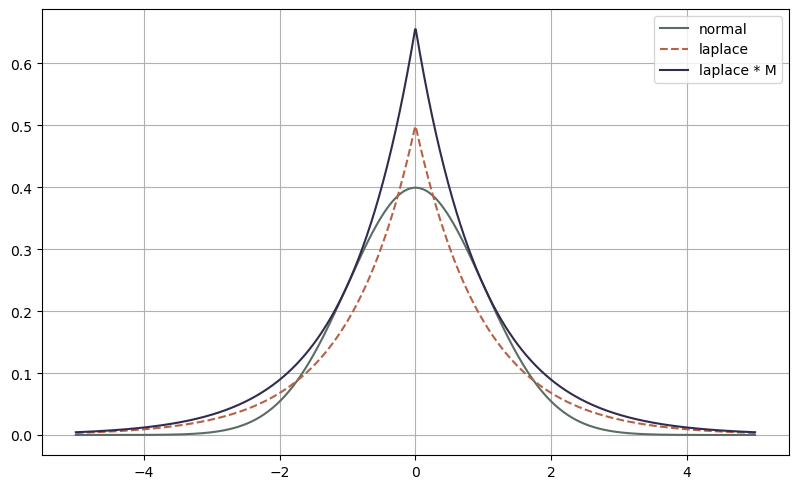

In [19]:
x_grid = np.linspace(-5, 5, 1000)

plt.plot(x_grid, normal_pdf(x_grid), label="normal")

plt.plot(x_grid, laplace_pdf(x_grid), label="laplace", ls="--")
plt.plot(x_grid, laplace_pdf(x_grid) * M, label="laplace * M")
plt.legend()
plt.show()

In [20]:
def laplace_sampler(size, lam = 1, rng = None):
    if rng is None:
        rng = np.random.default_rng(seed=42)
    U = rng.random(size) * 2 - 1
    return np.sign(U) * np.log(np.abs(U)) / lam

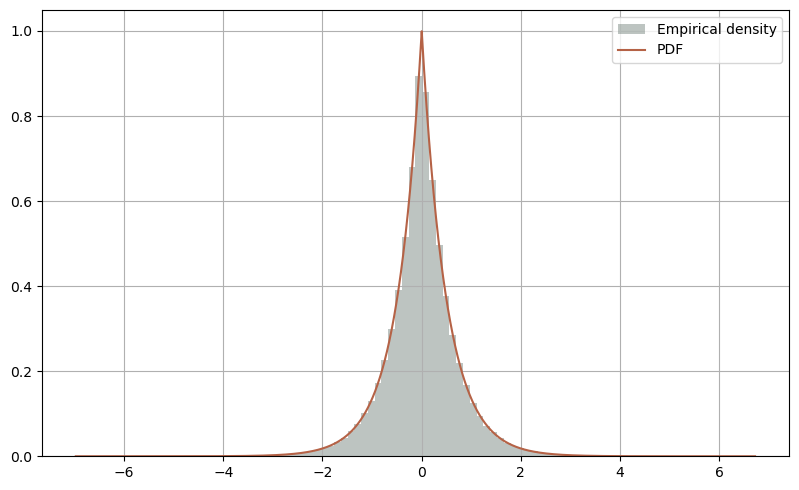

In [21]:
lam = 2
laplace_sample = laplace_sampler(size=10**6, lam=lam)
density_test(sample=laplace_sample, density=lambda x: laplace_pdf(x, lam=lam), bins=100)

In [22]:
def AR_sample(size: float, target_pdf: Callable, proposal_pdf: Callable, proposal_sampler: Callable, M: float, batch_size: float = None, rng=None):
    if rng is None:
        rng = np.random.default_rng(seed=42)
    
    if batch_size is None:
        batch_size = int(M * size + 3 * np.sqrt(M - 1) * np.sqrt(M * size + 3 * np.sqrt(M - 1) * np.sqrt(2 * M))) # Can you propose a reasonable guess?
    print("Batch size =", batch_size)
    
    sample = np.empty(size)
    ptr = 0
    total_accepted = 0
    iter_count = 0
    while ptr < size:
        proposal_sample = proposal_sampler(batch_size, rng=rng)
        uniform_sample = rng.random(batch_size)
        is_accepted = uniform_sample < target_pdf(proposal_sample) / proposal_pdf(proposal_sample) / M
        nb_accepted = np.sum(is_accepted)
        sample[ptr: ptr + nb_accepted] = proposal_sample[is_accepted][:size - ptr]
        ptr += nb_accepted
        total_accepted += nb_accepted
        iter_count += 1
    print("Acceptence proba =", total_accepted / batch_size / iter_count)
    return sample

Batch size = 1317421
Acceptence proba = 0.7599256426002015
Wall time: 204 ms


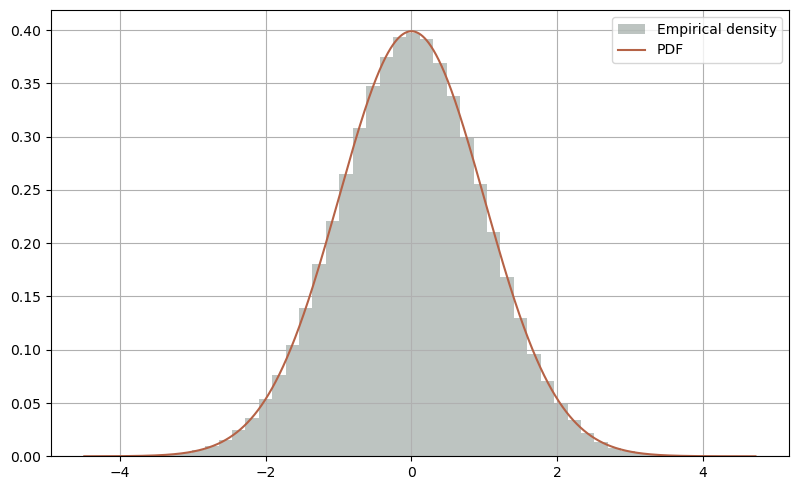

In [23]:
%%time

sample = AR_sample(size=10**6, target_pdf=normal_pdf, proposal_pdf=laplace_pdf, proposal_sampler=laplace_sampler, M=M)

density_test(sample, density=normal_pdf)

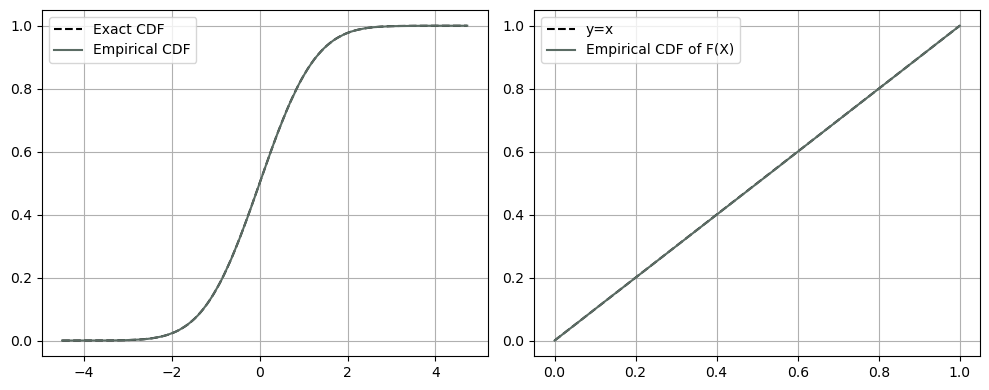

In [24]:
cdf_test(sample, cdf=norm.cdf)

#### Batch size matters!

In [25]:
%%time
sample = AR_sample(size=10**5, target_pdf=normal_pdf, proposal_pdf=laplace_pdf, proposal_sampler=laplace_sampler, M=M)

Batch size = 132160
Acceptence proba = 0.7580281476997579
Wall time: 13.4 ms


In [26]:
%%time
sample = AR_sample(size=10**5, target_pdf=normal_pdf, proposal_pdf=laplace_pdf, proposal_sampler=laplace_sampler, M=M, batch_size=1)

Batch size = 1
Acceptence proba = 0.7602828252109785
Wall time: 4.25 s


## **Problem 2.** Lookback option

In [28]:
def standard_brownian_motion_1d(t_grid, size, rng=None):
    """
    Simulates a "size" trajectories of a BM on t_grid.
    
    Returns: An array of shape (size, len(t_grid)).
    """
    if rng is None:
        rng = np.random.default_rng(seed=42)
    dt = np.diff(np.concatenate([[0], t_grid]))
    dW = rng.normal(size=(size, len(t_grid))) * np.reshape(np.sqrt(dt), (1, -1))
    W = np.cumsum(dW, axis=1)
    return W

Text(0.5, 1.0, 'Trajectories of the BM')

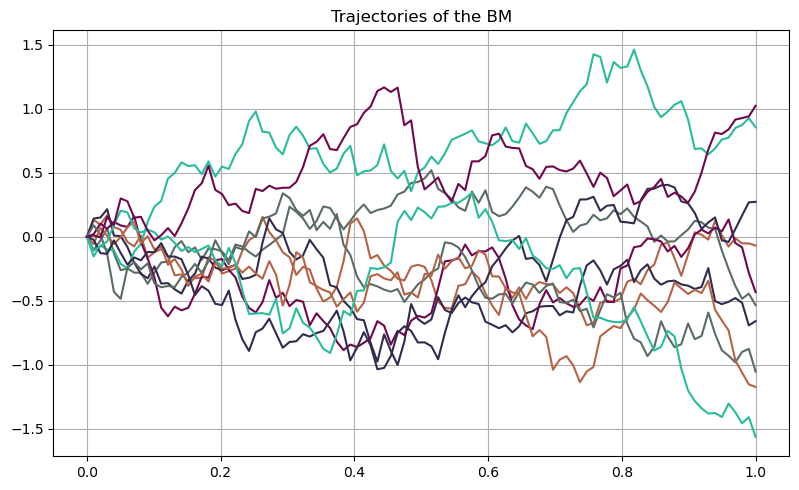

In [32]:
rng = np.random.default_rng(seed=42)
t_grid = np.linspace(0, 1, 100)
size = 10000

W = standard_brownian_motion_1d(t_grid=t_grid, size=size)
for i in range(10):
    plt.plot(t_grid, W[i])
    
plt.title("Trajectories of the BM")

##### How to test it?

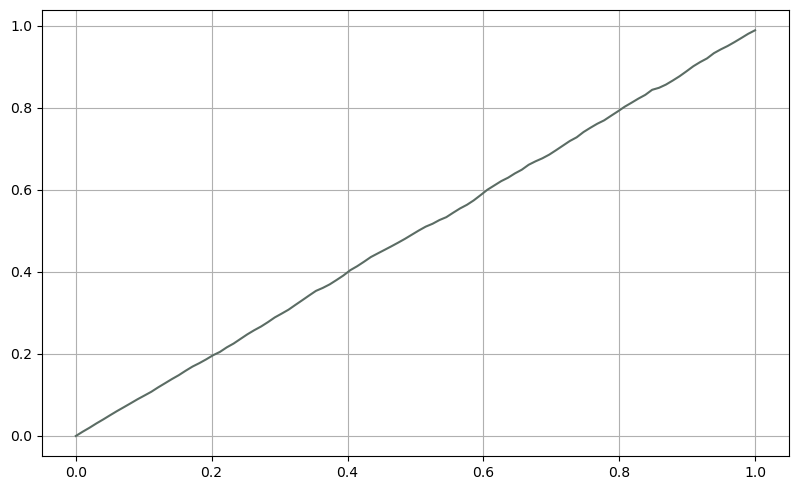

In [33]:
plt.plot(t_grid, np.mean(W**2, axis=0))

In [34]:
def geometric_brownian_motion(t_grid, size, rng=None, drift=0, vol=1, init_val=1):
    """
    Simulates "size" trajectoriees of the solution to
    dX_t / X_t = drift * dt + vol * dW_t,
    X_0 = init_val,
    on the given time grid.
    
    Returns: An array of shape (size, len(t_grid)).
    """
    if rng is None:
        rng = np.random.default_rng(seed=42)
    W = standard_brownian_motion_1d(t_grid=t_grid, size=size, rng=rng)
    X = init_val * np.exp((drift - 0.5 * vol**2) * np.reshape(t_grid, (1, -1)) + vol * W)
    return X

Text(0.5, 1.0, 'Trajectories of the GBM')

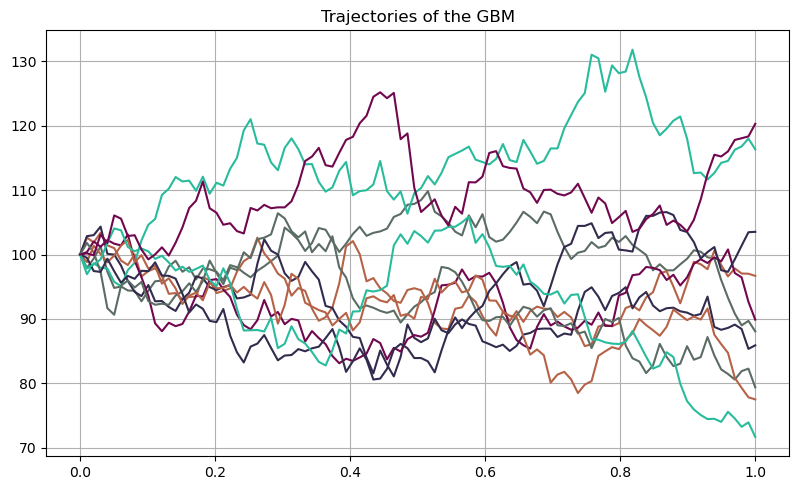

In [35]:
rng = np.random.default_rng(seed=42)
t_grid = np.linspace(0, 1, 100)
size = 10

X = geometric_brownian_motion(t_grid=t_grid, size=size, rng=rng, init_val=100, vol=0.2, drift=0)
for i in range(size):
    plt.plot(t_grid, X[i])
    
plt.title("Trajectories of the GBM")

##### How to test it?

### Back to our problem...

In [36]:
S0 = 100
r = 0.03
q = 0.02
sigma = 0.3

h = 1 / 12
m = 6
t_grid = np.arange(1, m + 1) * h

T = 0.5
K = 95
size = 10**6
rng = np.random.default_rng(seed=42)

In [37]:
prices = geometric_brownian_motion(t_grid=t_grid, size=size, rng=rng, drift=r-q, vol=sigma, init_val=S0)
min_prices = np.min(prices, axis=1)
discounted_payoff = np.exp(-r * T) * np.maximum(K - min_prices, 0)

Option price = 8.1154 ± 0.0183


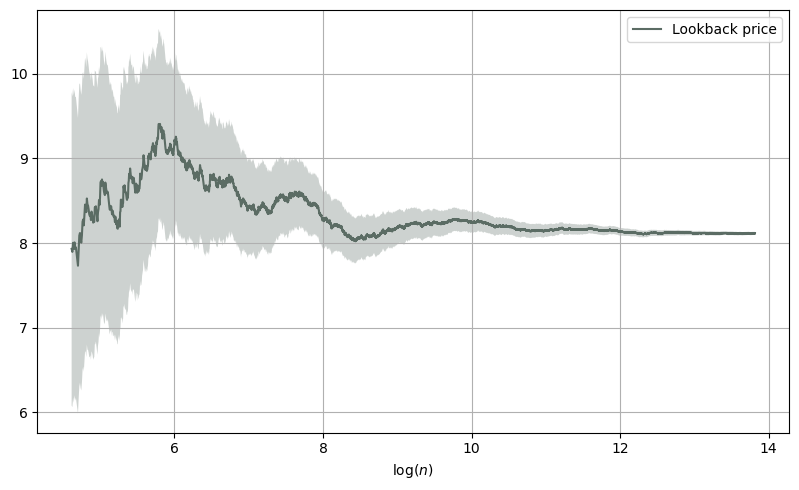

In [38]:
plot_convergence_diagram(discounted_payoff, label="Lookback price", plot_ci=True)
print("Option price =", mc_results(discounted_payoff))

## **Problem 3.** Multivariate normal $X \sim \mathcal{N}(\mu, \Sigma)$

In [39]:
mu = np.array([1, 2, 3])

cov_mat = np.array([
    [1, 0.6, 0.4],
    [0.6, 1, 0.5],
    [0.4, 0.5, 1]
])

##### Check the eigenvalues

In [40]:
np.linalg.eigvals(cov_mat)

array([2.00445753, 0.38245083, 0.61309164])

In [41]:
L = np.linalg.cholesky(cov_mat)
L

array([[1.        , 0.        , 0.        ],
       [0.6       , 0.8       , 0.        ],
       [0.4       , 0.325     , 0.85695683]])

##### Sanity check: $\Sigma = LL^T$

In [42]:
L @ L.T

array([[1. , 0.6, 0.4],
       [0.6, 1. , 0.5],
       [0.4, 0.5, 1. ]])

In [43]:
def multivariate_normal(size, mean, cov_mat, rng=None):
    if rng is None:
        rng = np.random.default_rng(seed=42)
        
    dim = len(mean)
    if cov_mat.shape != (dim, dim):
        raise ValueError("Dimensions of mean and cov_mat are inconsistent.")
    
    standard_normal = rng.normal(size=(size, dim))
    L = np.linalg.cholesky(cov_mat)
    return np.einsum("ij,kj->ki", L, standard_normal) # read the doc!

In [44]:
sample = multivariate_normal(size=10**5, mean=mu, cov_mat=cov_mat)

In [45]:
np.corrcoef(sample.T)

array([[1.        , 0.60140596, 0.40480655],
       [0.60140596, 1.        , 0.50147182],
       [0.40480655, 0.50147182, 1.        ]])

##### Tests...?

## **Problem 4.** Min-Call option

In [46]:
r = 0.05
sigmas = np.array([[0.2, 0.4]])
S0 = np.array([[100, 100]])
rho = 0.7

K = 95
T = 1

size = 10**6
rng = np.random.default_rng(seed=42)

In [47]:
cov_mat = np.array([
    [1, rho],
    [rho, 1]
])
W_T = multivariate_normal(size=size, mean=np.zeros(2), cov_mat=cov_mat) * np.sqrt(T)
S_T = S0 * np.exp((r - sigmas**2 / 2) * T + sigmas * W_T)

In [48]:
discounted_payoff = np.exp(-r * T) * np.maximum(np.min(S_T, axis=1) - K, 0)

Option price = 9.2494 ± 0.0293


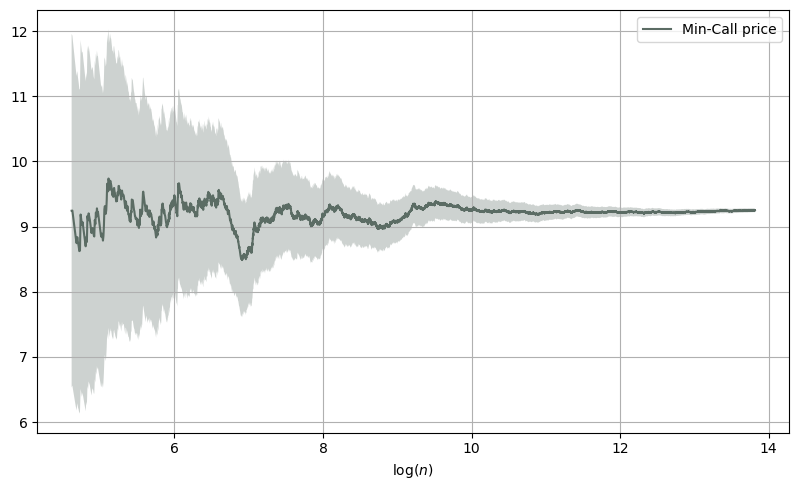

In [49]:
plot_convergence_diagram(discounted_payoff, label="Min-Call price", plot_ci=True)
print("Option price =", mc_results(discounted_payoff))

### __Problem.__ Can we generalize all the functions above to simulate multivariate correlated (geometric) Brownian motion?